# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print ('data shape: ', X.shape)
print ('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

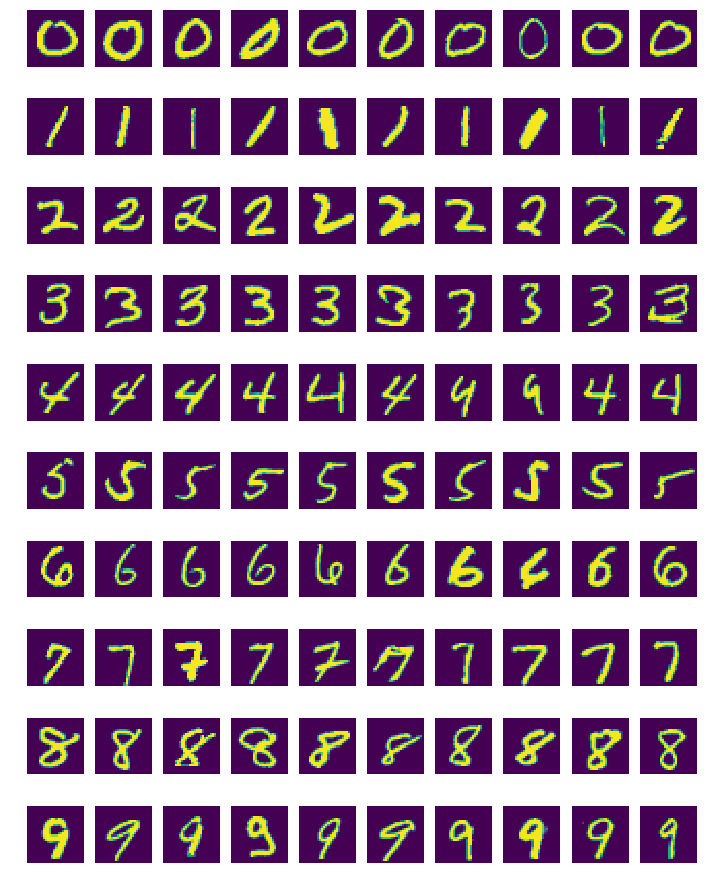

In [3]:
#def P1(num_examples=10):

### STUDENT START ###
def P1(num_examples=10):
    # Get an array of the 10 unique labels
    unique_digits = np.unique(Y)
    # Set up a 10X10 matplolib figure
    fig, ax = plt.subplots(10,10, figsize=(12,16))
    
    # Loop through the array of digits
    for row, digit in enumerate(unique_digits):
        # For each unique digit get the indices for rows where the label is that digit
        digit_indices = np.where(Y==digit)[0]
        ten_examples = X[digit_indices[:num_examples]] # Get examples for the digit equal to the num_eaxamples variable
        
        # Loop through the exaples for the digit and display them
        for column in range(num_examples):
            ax[row][column].axis('off')
            ax[row][column].imshow(ten_examples[column].reshape(28,28))
        

### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
#def P2(k_values):

### STUDENT START ###
def P2(k_values):
    
    # Loop through the list of k values
    for k in k_values:
        # Create a k-NN model with the current value of k and train it
        model = KNeighborsClassifier(n_neighbors=k) 
        model.fit(mini_train_data, mini_train_labels)
        
        # Make predicitions based on the dev data
        y_pred = model.predict(dev_data)
        accuracy = model_accuracy(y_pred, dev_labels) # Get the accuracy on the dev set
        print("For k = {} the accuracy is {}".format(k, accuracy))
        
        # Return the classification Report for k=1
        if k==1:
            print("The classfication report for k=1\n")
            print(classification_report(dev_labels, y_pred)) 

def model_accuracy(y_pred, y_true):
    '''
    A function that we shall use to get the model accuracy. It takes y_pred the predicted values and y_true the actual
    values and returns the accuracy of the model as a percentage
    '''
    correctly_predicted = np.sum(y_pred == y_true) # Get the number of data points where y_pred is equal to y_true
    percent_accuracy = 100 * correctly_predicted /len(y_pred) # Get the percentage of values predicted correctly
    return percent_accuracy
    
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

For k = 1 the accuracy is 88.8
The classfication report for k=1

             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

For k = 3 the accuracy is 87.8
For k = 5 the accuracy is 86.9
For k = 7 the accuracy is 86.5
For k = 9 the accuracy is 86.3


ANSWER: The most difficult digit is 9. It has the lowest f1-score

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
def P3(train_sizes, accuracies):

### STUDENT START ###

    # Loop through each of the train_sizes
    for size in train_sizes:
        
        # Create a 1-NN model and train it with the data set size
        model = KNeighborsClassifier(n_neighbors=1)
        model.fit(train_data[:size], train_labels[:size])
        
        #Obtain the timebefore and after making predictions and calculate the difference
        start = time.time()
        y_pred = model.predict(dev_data)
        finish = time.time()
        time_difference = round((finish - start), 3)
        
        #Calculate the accuracy and print it together with the amount of time taken
        accuracy = model_accuracy(y_pred, dev_labels)
        accuracies.append(accuracy)
        print("The accuracy for train size {} is {}. The time taken to make predictions is {}s".format(size, accuracy, time_difference))

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

The accuracy for train size 100 is 72.0. The time taken to make predictions is 0.157s
The accuracy for train size 200 is 78.6. The time taken to make predictions is 0.313s
The accuracy for train size 400 is 84.1. The time taken to make predictions is 0.633s
The accuracy for train size 800 is 88.4. The time taken to make predictions is 1.329s
The accuracy for train size 1600 is 90.2. The time taken to make predictions is 2.491s
The accuracy for train size 3200 is 92.6. The time taken to make predictions is 5.174s
The accuracy for train size 6400 is 93.7. The time taken to make predictions is 10.044s
The accuracy for train size 12800 is 95.9. The time taken to make predictions is 21.414s
The accuracy for train size 25000 is 97.0. The time taken to make predictions is 39.548s


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [6]:
def P4(accuracies, train_sizes):

### STUDENT START ###
    # Create a linear regression model and train in
    linear_model = LinearRegression()
    
    # Turn the accuracies and train sizes lists to arrays and reshape them
    accuracies = np.array(accuracies).reshape(-1,1)
    train_sizes = np.array(train_sizes).reshape(-1,1)
    
    # Fit a regression model and and make a predcition
    linear_model.fit(train_sizes, accuracies)
    predicted_value = linear_model.predict(60000)
    return predicted_value[0][0]

### STUDENT END ###
                     
P4(accuracies, train_sizes)


124.30722603554992

ANSWER: The issue is that predicted values of the regression are not bounded between 0 and 100%. A possible solution would be to use a logit transformation on the data

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

The confusion matrix for the model is
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]] 


Examples of 4s predicted as 9s followed by examples of 9s predicted as 4s


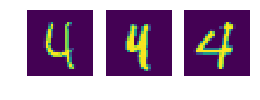

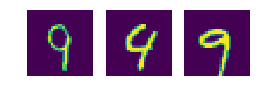

In [7]:
def P5():

### STUDENT START ###
    
    # Train a 1-NN model
    model_1nn = KNeighborsClassifier(n_neighbors=1)
    model_1nn.fit(mini_train_data, mini_train_labels)
    
    # Make predictions and output the confusion matrix
    y_pred = model_1nn.predict(dev_data)
    print("The confusion matrix for the model is")
    print(confusion_matrix(dev_labels, y_pred), '\n\n')
    
    # Obtain the data points as 9s yet they are 4s
    wrong_predicted4 = np.logical_and(y_pred==9, dev_labels==4)
    wrong_predicted4_array = dev_data[wrong_predicted4]
    
    # Make a subplot of 3 wrongly predicted 4s
    print("Examples of 4s predicted as 9s followed by examples of 9s predicted as 4s")
    fig, ax = plt.subplots(1,3, figsize=(4,6))
    for example in range(3):
        ax[example].axis('off')
        ax[example].imshow(wrong_predicted4_array[example].reshape(28,28))
    
    # Obtain the data points as 9s yet they are 4s
    wrong_predicted9 = np.logical_and(y_pred==4, dev_labels==9)
    wrong_predicted9_array = dev_data[wrong_predicted9]
    
    # Make a subplot of 3 wrongly predicted 4s
    fig, ax = plt.subplots(1,3, figsize=(4,6))
    for example in range(3):
        ax[example].axis('off')
        ax[example].imshow(wrong_predicted9_array[example].reshape(28,28))
    
    
### STUDENT END ###

P5()

ANSWER: The most confused digits are 4 and 9

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [8]:
from scipy.ndimage import gaussian_filter

def P6():
    
### STUDENT START ###

    # Create a 3X3 gaussian kernel
    ax = np.arange(-3 // 2 + 1, 3 // 2 + 1)
    x, y = np.meshgrid(ax, ax)
    kernel = np.exp(-(x**2 + y**2) / (2. * 1**2))
    kernel = kernel / np.sum(kernel)
    
    # Define a method to apply the kernel to the different rows
    def apply_kernel(row):
        return np.convolve(row, kernel.ravel(), mode='same')
    
    # Apply the kernel to the train and dev sets
    gaussian_train_data = np.apply_along_axis(apply_kernel, 0, mini_train_data)
    gaussian_dev_data = np.apply_along_axis(apply_kernel, 0, dev_data)
    
    
    print("With filter on training data only:")
    
    # Create a model and train it on a filtered data set but without applying the kernel to the dev set
    knn_filter_model1 = KNeighborsClassifier(n_neighbors=3)
    knn_filter_model1.fit(gaussian_train_data, mini_train_labels)
    y_pred = knn_filter_model1.predict(dev_data)
    
    # Return the accuracy of the model
    accuracy1 = model_accuracy(y_pred, dev_labels)
    print("The accuracy of the model is {}\n".format(round(accuracy1,3)))
    
    print("With filter on dev data only:")
    
    # Create a model and train it on the mini data set and evaluate it on the filtered dev set
    knn_filter_model2 = KNeighborsClassifier(n_neighbors=3)
    knn_filter_model2.fit(mini_train_data, mini_train_labels)
    y_pred = knn_filter_model2.predict(gaussian_dev_data)
    
    # Return the accuracy of the model
    accuracy2 = model_accuracy(y_pred, dev_labels)
    print("The accuracy of the model is {}\n".format(round(accuracy2,3)))
    
    print("With a filter on both train and dev data:")
    
    # Create a model and train it on the filtered mini data and dev sets
    knn_filter_model3 = KNeighborsClassifier(n_neighbors=3)
    knn_filter_model3.fit(gaussian_train_data, mini_train_labels)
    y_pred = knn_filter_model3.predict(gaussian_dev_data)
    
    # Return the accuracy of the model
    accuracy3 = model_accuracy(y_pred, dev_labels)
    print("The accuracy of the model is {}\n".format(round(accuracy3,3)))

### STUDENT END ###

P6()


With filter on training data only:
The accuracy of the model is 63.0

With filter on dev data only:
The accuracy of the model is 34.0

With a filter on both train and dev data:
The accuracy of the model is 27.7



ANSWER:

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [9]:
def P7():

### STUDENT START ###
    
    # Turn the values in the train and dev sets into binary values
    train_data_binary = np.where(mini_train_data<0.5, 0, 1)
    dev_data_binary = np.where(dev_data<0.5, 0, 1)
    
    # Fit a BernoulliNB model on the binary data and print the accuracy
    model_bernoulli = BernoulliNB()
    model_bernoulli.fit(train_data_binary, mini_train_labels)
    
    # Make predictions on the dev set 
    y_pred = model_bernoulli.predict(dev_data)
    accuracy = model_accuracy(y_pred, dev_labels)
    print('For BernoulliNB the accuracy is {}'.format(accuracy))
    
    multinomial_divider = 1/3 # A number used to divided the range of feature values into 3
    
    # Create multinomial features fro the train and dev sets using the multinomial_divider variable
    train_data_multinomial = np.where(mini_train_data <= multinomial_divider, 0, np.where(mini_train_data <= multinomial_divider*2, 1,2))
    dev_data_multinomial = np.where(dev_data <= multinomial_divider, 0, np.where(mini_train_data <= multinomial_divider*2, 1,2))
    
    # Fit a MultinomialNB model on the nultinomial data
    model_multinomial = MultinomialNB()
    model_multinomial.fit(train_data_multinomial, mini_train_labels)
    
    # Make predictions on the dev set and print the accuracy
    y_pred = model_multinomial.predict(dev_data_multinomial)
    accuracy = model_accuracy(y_pred, dev_labels)
    print('For MultinomialNB the accuracy is {}'.format(accuracy))
    
### STUDENT END ###

P7()

For BernoulliNB the accuracy is 79.6
For MultinomialNB the accuracy is 79.6


ANSWER: MutinomialNB does not improve the results. This is likely because it is only important if a pixel is dark or not (0 or 1). There is no additional information provided by creating a third level

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [10]:
def P8(alphas):

### STUDENT START ###
    
    # Create a GridSearch model using the BernoulliNB model with 5 folds and train models for the different alpha values
    bernoullicv = GridSearchCV(BernoulliNB(binarize=0.5), param_grid=alphas, cv=5)
    bernoullicv.fit(mini_train_data, mini_train_labels)
    
    # Return the trained model
    return bernoullicv

### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

/Users/Elizabeth/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/Elizabeth/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/Elizabeth/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/Elizabeth/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/Elizabeth/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'settin

In [11]:
print (nb.best_params_) # Print the best parameters found by grid search

print (nb.grid_scores_) # print the scores for the other parameter values

{'alpha': 0.0001}
[mean: 0.81000, std: 0.02070, params: {'alpha': 0.0}, mean: 0.82000, std: 0.02494, params: {'alpha': 0.0001}, mean: 0.81900, std: 0.02676, params: {'alpha': 0.001}, mean: 0.81900, std: 0.02668, params: {'alpha': 0.01}, mean: 0.81400, std: 0.02800, params: {'alpha': 0.1}, mean: 0.80600, std: 0.02232, params: {'alpha': 0.5}, mean: 0.80200, std: 0.02307, params: {'alpha': 1.0}, mean: 0.80000, std: 0.01915, params: {'alpha': 2.0}, mean: 0.74000, std: 0.02638, params: {'alpha': 10.0}]


/Users/Elizabeth/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


ANSWER: The accuracy for alpha = 0 is 0.81. This is the scenario without smoothing and as  we would expect, the accuracy is worse than the best case scenario with smoothing at 0.001.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [12]:
def P9():

### STUDENT END ###
    
    #Train a Gaussian Naive Bayes model and obtian the accuracy of it's predictions on the dev set
    gaussian_model = GaussianNB()
    gaussian_model.fit(mini_train_data, mini_train_labels)
    y_pred = gaussian_model.predict(dev_data)
    accuracy = model_accuracy(y_pred,dev_labels)
    
    #return the accuracy of the model
    print ("The accuracy of the Gaussian Naive Bayes model is:")
    return accuracy 

### STUDENT END ###

gnb = P9()
print (gnb)

print('\n')


def P9():
    gaussian_model = GaussianNB()
    
    # determine the mean and standard deviation for each of the features
    means = np.mean(mini_train_data, axis=0)
    stds = np.std(mini_train_data, axis=0)
    
    # normalize the train and dev sets
    normalized_mini_train_data = (mini_train_data - means.reshape(1,-1))/(stds.reshape(1,-1)+1)
    normalized_dev_data = (dev_data - means.reshape(1,-1))/(stds.reshape(1,-1)+1)
    
    # Train a Gaussian Naive Bayes model on the normalized train data and make predictions
    gaussian_model.fit(normalized_mini_train_data, mini_train_labels)
    y_pred = gaussian_model.predict(normalized_dev_data)
    
    print ("The accuracy when using normalized data is:")
    accuracy = model_accuracy(y_pred, dev_labels)
    return accuracy

P9()


The accuracy of the Gaussian Naive Bayes model is:
62.1


The accuracy when using normalized data is:


61.7

ANSWER: The problem is that the Gaussian Naive Bayes classifier expects data that is normally distributed while the features we passed to it do not have normally distributed data. The solution is to normailze the data by substracting the mean of each feature from the data and standardizing by dividing the result by the feature's standard deviation for each data point.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

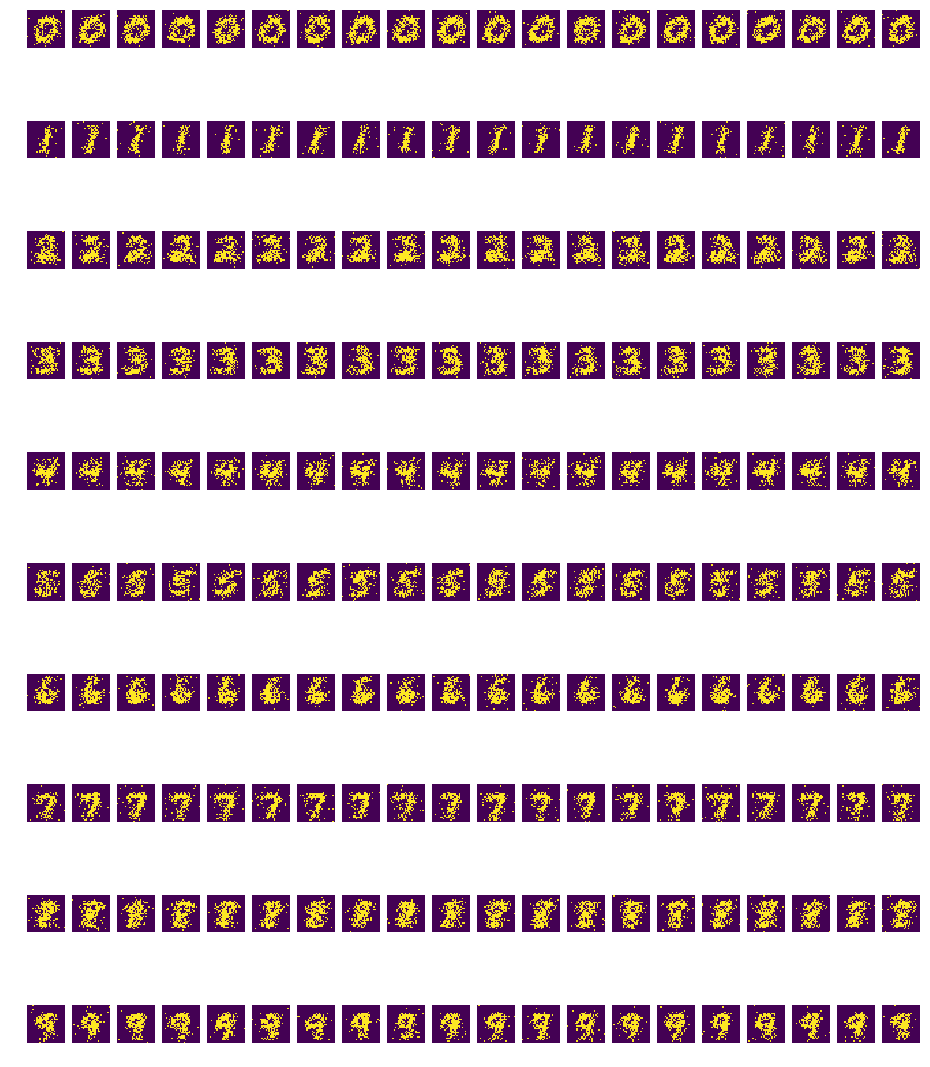

In [13]:
def P10(num_examples):

### STUDENT START ###

    # Fit a Bernolli model and train it on the mini data set
    bernoulli_model = BernoulliNB()
    bernoulli_model.fit(mini_train_data, mini_train_labels)
    
    # Convert the log probabilites learnt by the model to probabilites between 0 and 1
    log_probabilities = bernoulli_model.feature_log_prob_
    probabilities = np.exp(log_probabilities)
    
    # Generate a matrix of random numbers with depth of num_examples
    random_matrix = np.random.rand(10,784, num_examples)
    
    # Use the random matrix to generate trainng examples from the probabilities of each feature for each digit
    generated_digits = np.where(random_matrix < probabilities.reshape(10,-1,1), 1, 0)
    
    # Create a 10X20 grid to display 20 examples for each digit from the generated examples
    fig, ax = plt.subplots(10,20, figsize=(16,20))
    for row, digit in enumerate(range(10)):
        for column in range(num_examples):
            ax[row][column].axis('off')
            ax[row][column].imshow(generated_digits[row, :, column].reshape(28,28))
    

### STUDENT END ###

P10(20)

ANSWER: The generated digits are good approximations of the training digits. They have the general shape of the training digits even though they are not as well defined and have a lot of noise.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [14]:
def P11(buckets, correct, total):
    
### STUDENT START ###

    # Create a Bernoulli naive Bayes model and train it on the mini data set
    calibration_model = BernoulliNB(alpha=0.0001)
    calibration_model.fit(mini_train_data, mini_train_labels)
    
    # Get the predicted probabilities of the different digits for each data point in the dev set
    predicted_probabilites = calibration_model.predict_proba(dev_data)
    
    # Get the predictions on the dev set and get the data points that were predicted correctly
    y_pred = calibration_model.predict(dev_data)
    predicted_correct = y_pred == dev_labels
    
    # Create an array of the maximum predicted probability for each data point
    max_posterior = np.max(predicted_probabilites, axis=1)
    
    # Loop through the different values in the buckets list
    for position, value in enumerate(buckets):
        if position==0:
            # If it is the first bucket get the rows with values less than or equal to the value of the first bucker
            total_array = max_posterior<=buckets[position]
        else:
            # Otherwise get the rows with values between the last bucket value and the current one
            total_array = np.logical_and(max_posterior<=buckets[position], max_posterior>buckets[position-1])
            
        # Add the total number of rows for the bucket to the total list
        total[position] = np.sum(total_array)
        
        # Create an array for the rows that were predicted correctly and are also in this bucket
        correct_array = np.logical_and(total_array, predicted_correct)
        # Add the number of correctly predictd rows for the bucket to the correct list
        correct[position] = np.sum(correct_array)
            
                
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
   accuracy = 0.0
   if (total[i] > 0): accuracy = correct[i] / total[i]
   print ('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total =   1    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  34    accuracy = 0.471
p(pred) <= 0.9990000000000    total =  59    accuracy = 0.407
p(pred) <= 0.9999900000000    total =  59    accuracy = 0.525
p(pred) <= 0.9999999000000    total =  59    accuracy = 0.593
p(pred) <= 0.9999999990000    total =  41    accuracy = 0.512
p(pred) <= 0.9999999999900    total =  50    accuracy = 0.700
p(pred) <= 0.9999999999999    total =  40    accuracy = 0.775
p(pred) <= 1.0000000000000    total = 657    accuracy = 0.944


ANSWER: The Naive Bayes model is weakly calibrated. Accuracy increases with posterior probability but not proportionaly.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [15]:
def P12():

### STUDENT START ###
    '''
    This function creates four new features: One for each of the sums of pixel values in the top, bottom, left and 
    right halves of a digit
    '''

    # Reshape the train data to 28X28 for each digit
    reshaped_train_data = mini_train_data.reshape(-1, 28,28)

    # Calculate the sum of pixel values for each of the halves for each digit in the train data
    top_half_sum_train = np.sum(reshaped_train_data[:, :, :14], axis=(1,2)).reshape(-1,1)
    bottom_half_sum_train = np.sum(reshaped_train_data[:, :, 14:], axis=(1,2)).reshape(-1,1)
    left_half_sum_train = np.sum(reshaped_train_data[:, :14, :], axis=(1,2)).reshape(-1,1)
    right_half_sum_train = np.sum(reshaped_train_data[:, 14:, :], axis=(1,2)).reshape(-1,1)
    
    # Create new train data set with the 4 extra features
    train_data_half_sums = np.concatenate((mini_train_data,top_half_sum_train, bottom_half_sum_train, left_half_sum_train, right_half_sum_train), axis=1)
    
    # Reshape the dev data to 28X28 for each digit
    reshaped_dev_data = dev_data.reshape(-1, 28,28)
    
    # Calculate the sum of pixel values for each of the halves for each digit in the dev data
    top_half_sum_dev = np.sum(reshaped_dev_data[:, :, :14], axis=(1,2)).reshape(-1,1)
    bottom_half_sum_dev = np.sum(reshaped_dev_data[:, :, 14:], axis=(1,2)).reshape(-1,1)
    left_half_sum_dev = np.sum(reshaped_dev_data[:, :14, :], axis=(1,2)).reshape(-1,1)
    right_half_sum_dev = np.sum(reshaped_dev_data[:, 14:, :], axis=(1,2)).reshape(-1,1)
    
    # Create new dev data set with the 4 extra features
    dev_data_half_sums = np.concatenate((dev_data, top_half_sum_dev, bottom_half_sum_dev, left_half_sum_dev, right_half_sum_dev), axis=1)

    # train a Bernoulli naive Bayes classifier on the new train data
    features_model = BernoulliNB(binarize=0.5, alpha=0.0001)
    features_model.fit(train_data_half_sums, mini_train_labels)
    
    # Make predictions and obtain the accuracy of the model
    y_pred = features_model.predict(dev_data_half_sums)
    accuracy = model_accuracy(y_pred, dev_labels)

    print(accuracy)


### STUDENT END ###

P12()

81.7


ANSWER: Added the sums of the different halves of a digit as features. This produced a model that was similar in performance to those created above